<a href="https://colab.research.google.com/github/jamespan1118/Xenopus_signal_processing/blob/main/Viterbi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Objective: Create segments that contains bouts of calling

####Preparation work

Input: original recording

Output: segments of recordings containing bouts of calling

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import librosa
import os
from librosa import display
import scipy
import numpy as np
from matplotlib import pyplot as plt
import math

In [3]:
from scipy import fftpack, signal
from scipy.io.wavfile import write
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft

High-pass and Low-pass filter to remove noise

In [4]:
def load_wav(file_path, sampling_rate = 44100):
  file_name = os.path.basename(file_path)
  samples, sampling_rate = librosa.load(file_path,sr=sampling_rate)
  duration = len(samples)/sampling_rate
  return(samples, sampling_rate, duration)

def filt(samples, sampling_rate=44100, low_thresh=400, upp_thresh=5000): 
  yf = rfft(samples)
  xf = rfftfreq(len(samples), 1 / sampling_rate)
  points_per_freq = len(xf) / (sampling_rate / 2)

  target_idx_noise_lower = int(points_per_freq * low_thresh)
  target_idx_noise_upper = int(points_per_freq * upp_thresh)
  yf[: target_idx_noise_lower] = 0
  yf[target_idx_noise_upper:] = 0
  filt_signal = irfft(yf)
  return filt_signal

Rough filter for feature extraction

In [5]:
def norm_envelope(samples, sampling_rate=44100, win_length=2048, win_step=1024):
  y = np.pad(samples, win_length, mode="constant")
    # Pads (window length) to the sequence: -->windows around sample of length 1024*5 (samples)
  x = librosa.util.frame(y, win_length, win_step) # step-size 512
  sm_env = np.sqrt(np.mean(np.abs(x)**2, axis=-2, keepdims=True))
  z_env = z_score(sm_env)
  
  frames = np.arange(z_env.shape[1])
  frames_dist=(np.array(frames) * win_step).astype(int)
  times=np.array(frames_dist) / float(sampling_rate)
  return sm_env, z_env, times

def z_score(data):
  error = math.exp(-100)
  if(np.std(data)<0.001):
    error=0.005
  z = (data)/(np.std(data)+error) # The filter's pretty strong so let's just normalize by standard deviation. But error should = threshold?
  return z

Generate the likelihood of calling at each point

In [6]:
def logistic_function(x,threshold,std):
  probability = 1/(1+math.exp(-(x-threshold)/std))
  return probability

def state_probability(z_env):
  vectorized_logistics = np.vectorize(logistic_function)
  std_normalized = np.std(z_env)
  #data points with z_score>3 categorized into yes call state
  probability_each_point = vectorized_logistics(z_env, 0.02, std_normalized)
  return probability_each_point

Generate input parameters for the viterbi algorithm

In [7]:
def prob_generate(probability_each_point):
  yes_call_prob = probability_each_point
  no_call_prob = [1-i for i in yes_call_prob]
  prob = np.row_stack((yes_call_prob,no_call_prob))
  return prob

In [8]:
#assumption that the transition between states is less likely compared to within states
yes_to_no = 0.4
no_to_yes = yes_to_no
transition_matrix = np.row_stack(([1-yes_to_no,yes_to_no],[no_to_yes,1-no_to_yes]))

In [9]:
p_init = np.array([0.5,0.5])

####testing to ensure the function works

In [10]:
file_path = '/content/drive/MyDrive/Xenopus_male_female_data/overall_copy/laevis/F818D-F8387/duets/chunks/rapping/01-F818D-F8387-220616_0905_2'

In [11]:
samples, sampling_rate, duration = load_wav(file_path)
x_time = np.arange(0,duration,1/sampling_rate)

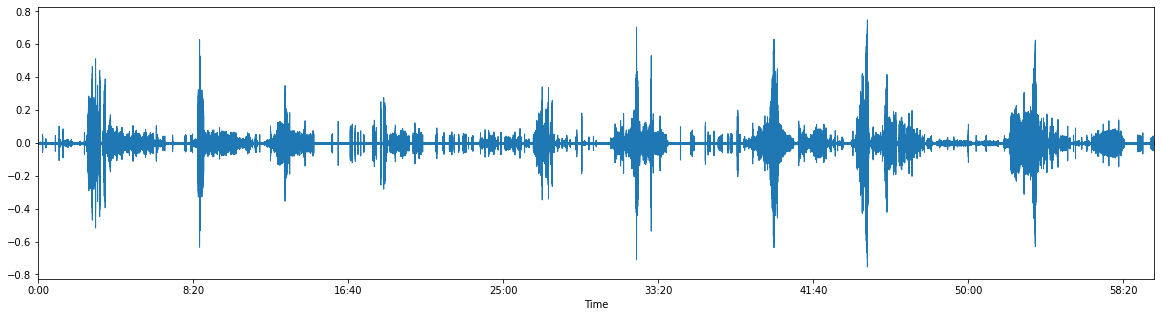

In [12]:
plt.figure(figsize=(20,5))
display.waveplot(samples,sr=sampling_rate)

In [13]:
sample_filt=filt(samples)

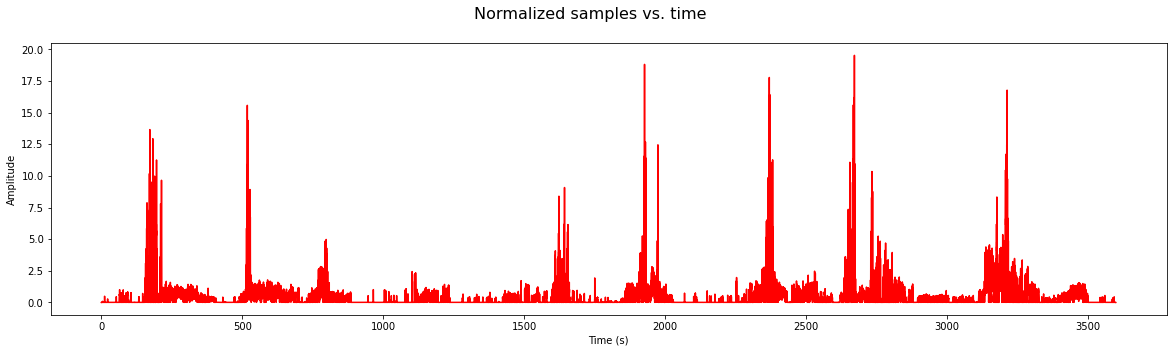

In [14]:
sm_env, z_env, times = norm_envelope(sample_filt, sampling_rate, win_length=1024*5, win_step=1024)
figure,ax1 = plt.subplots()
figure.set_size_inches(20,5)
#ax1.plot(times,sm_env[0],color='red')
ax1.plot(times,z_env[0],color='red')
#ax1.plot(x_time,samples,color='blue')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")
figure.suptitle('Normalized samples vs. time', fontsize=16)
#ax1.set_xlim(120,150)
#ax1.set_ylim(0,1)
plt.show()

In [15]:
np.std(sm_env[0])

0.005571663

In [16]:
probability_each_point = state_probability(z_env)

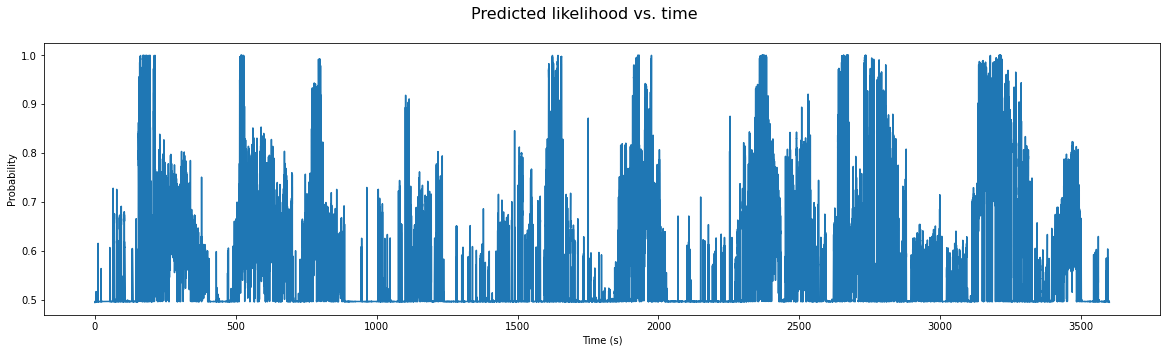

In [17]:
figure,ax1 = plt.subplots()
figure.suptitle('Predicted likelihood vs. time', fontsize=16)
figure.set_size_inches(20,5)
ax1.plot(times,probability_each_point[0])
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Probability")
#ax1.set_xlim(110,170)
plt.show()

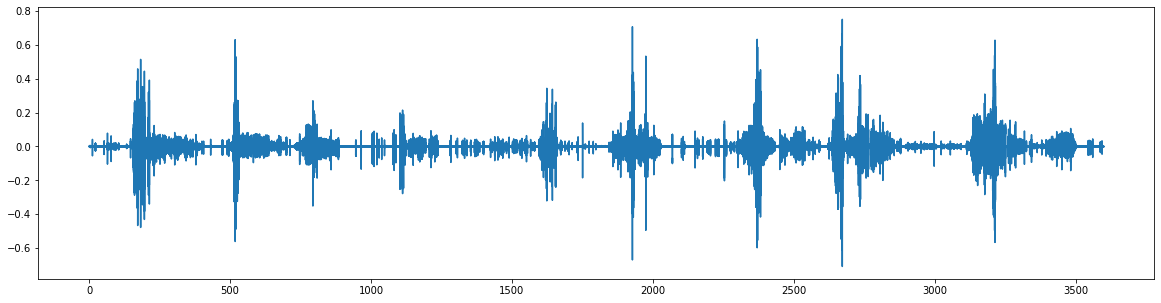

In [18]:
plt.figure(figsize=(20,5))
plt.plot(x_time, samples)
#plt.xlim(110,170)

In [19]:
prob = prob_generate(probability_each_point)

In [20]:
states = librosa.sequence.viterbi_discriminative(prob,transition_matrix, p_init=p_init)
states= 1-states

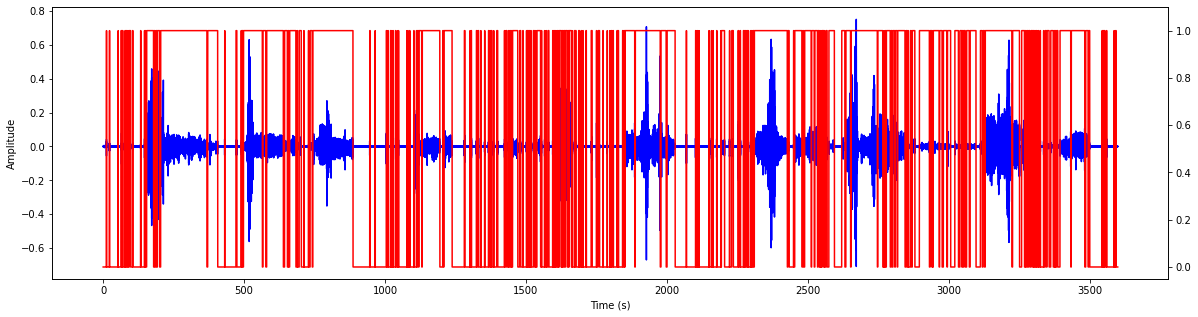

In [21]:
figure,ax1 = plt.subplots()
figure.set_size_inches(20,5)
ax1.plot(x_time,samples,color='blue')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")

ax2 = ax1.twinx()
ax2.plot(times,states,color='red')
ax2.set_ylim(-0.05,1.1)
#plt.xlim(110,170)
plt.show()

In [22]:
states

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
import pickle
pickle_out = open("state.pickle","wb")
pickle.dump(states,pickle_out)
pickle_out.close()

In [24]:
pickle_in = open("state.pickle","rb")
states = pickle.load(pickle_in)

In [36]:
start_call_index=[]
end_call_index=[]
for i in range(0,len(states)-1):
  if((states[i]==0)and(states[i+1]==1)):
    start_call_index.append(i+1)
  elif((states[i]==1)and(states[i+1]==0)):
    end_call_index.append(i)
  i=i+1

In [ ]:
#need the time conversion

####Official Execution

In [10]:
def run_viterbi(file_path):
  samples, sampling_rate, duration = load_wav(file_path)
  x_time = np.arange(0,duration,1/sampling_rate)
  sample_filt=filt(samples)
  sm_env, z_env, times = norm_envelope(sample_filt, sampling_rate, win_length=1024*5, win_step=1024)
  probability_each_point = state_probability(z_env)
  prob = prob_generate(probability_each_point)
  states = librosa.sequence.viterbi_discriminative(prob,transition_matrix, p_init=p_init)
  states= 1-states
  
  figure,ax1 = plt.subplots()
  figure.set_size_inches(20,5)
  ax1.plot(x_time,samples,color='blue')
  ax1.set_xlabel("Time (s)")
  ax1.set_ylabel("Amplitude")

  ax2 = ax1.twinx()
  ax2.plot(times,states,color='red')
  ax2.set_ylim(-0.05,1.1)
  #plt.xlim(110,170)
  plt.show()
  return states

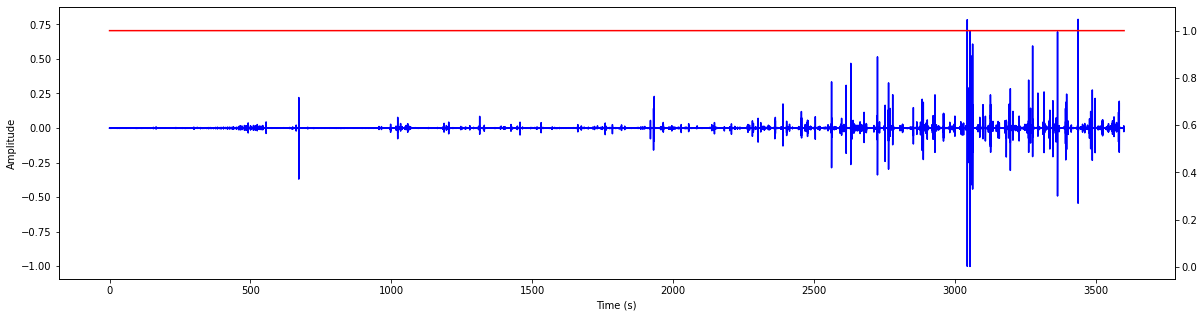

array([1, 1, 1, ..., 1, 1, 1])

In [11]:
run_viterbi('/content/drive/MyDrive/Xenopus_male_female_data/overall_copy/laevis/F818D-F8387/duets/chunks/rapping/01-F818D-F8387-220615_1834_1')

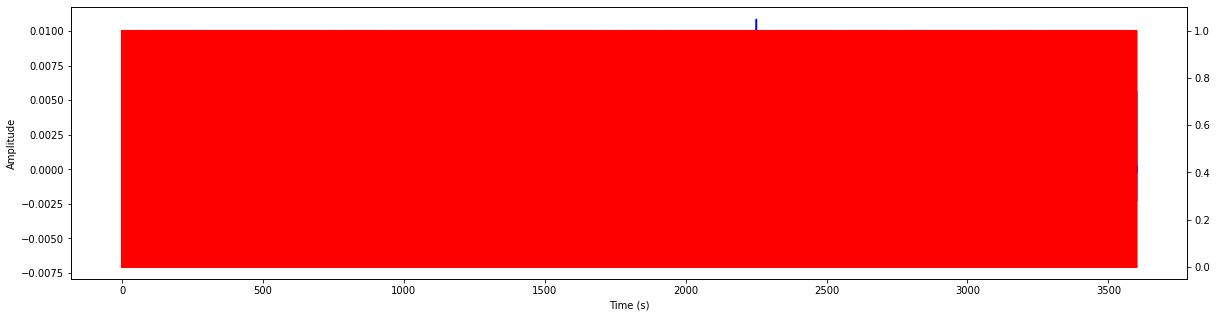

array([0, 0, 0, ..., 0, 0, 0])

In [12]:
run_viterbi('/content/drive/MyDrive/Xenopus_male_female_data/overall_copy/laevis/F818D-F8387/duets/chunks/ticking/01-F818D-F8387-220616_1219_2')

In [34]:
# rle:
000000
111
3

#states
# Rle (compression)**
# np.diff (0-->0=>0, search for any non-zero and find index)
startsec=[0, 20]
endsec=[19, 30]
import pandas as pd
pd.DataFrame({'start': startsec, 'end': endsec, 'call':[True, False]})
# soundfile.write_wav(wave_filename.split('.wav')+'_start'+startsec+'_end')

pd.to_csv(wave_filename.split('.wav')+'.csv')

x =0
librosa.load(wave_file, start=startsec[x], duration=endsec[x]-startsec[x])


AttributeError: ignored